In [1]:
import os
import pywt
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

from src.models.simple import SimpleCNN

import yaml
import pickle
import importlib
from types import SimpleNamespace
from quantus.metrics import Complexity

from physioex.physioex.data import PhysioExDataModule
from physioex.physioex.train.models.load import load_model

from src.utils import split_string
from src.attribution import compute_attribution
from src.evaluation.evaluation import evaluate_attributions


/Users/alicia/Documents/Master/TFM/learnable-masks-explainability-time-series/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_seed(seed: int = 42):
    random.seed(seed)                          # Python built-in random
    np.random.seed(seed)                       # NumPy random
    torch.manual_seed(seed)                    # CPU random seed
    torch.cuda.manual_seed(seed)               # GPU random seed (if used)
    torch.cuda.manual_seed_all(seed)           # All GPUs (if multiple GPUs)

    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Optional: for hash-based operations
    os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
# set seed
set_seed(42)

# to mps if available otherwise to cpu
device = torch.device('mps' if torch.backends.mps.is_available()  else 'cpu')
print(f"Using device: {device}")

Using device: mps


In [4]:
target_package = "physioex.train.networks.utils.target_transform"
target_class = "get_mid_label"
target = getattr(importlib.import_module(target_package), target_class)

set_seed(42)

datamodule = PhysioExDataModule(
    datasets=["sleepedf"],     # list of datasets to be used
    batch_size=128,            # batch size for the DataLoader
    preprocessing="raw",       # preprocessing method
    selected_channels=["EEG"], # channels to be selected
    sequence_length=7,         # length of the sequence
    target_transform= target,  # since seq to epoch, target seq
    num_workers = 8,          # number of parallel workers
    data_folder = "data"    # path to the data folder
)

In [5]:
# get the test DataLoaders
test_loader = datamodule.test_dataloader()

print(len(test_loader)) # number of batches in the test set

206


In [6]:
# load the model
with open("./config.yaml", "r") as file:
        config = yaml.safe_load(file)

network_config = config["model_config"]

# load the model class
model_package, model_class = config["model"].split(":")
model_class = getattr(importlib.import_module(model_package), model_class)

# casting the float types
network_config['learning_rate'] = float(network_config['learning_rate'])
network_config['weight_decay'] = float(network_config['weight_decay'])
network_config['adam_beta_1'] = float(network_config['adam_beta_1'])
network_config['adam_beta_2'] = float(network_config['adam_beta_2'])
network_config['adam_epsilon'] = float(network_config['adam_epsilon'])

model_path = "./model/checkpoint/fold=-1-epoch=19-step=19898-val_acc=0.83.ckpt"
model = load_model(
    model = model_class,
    model_kwargs = network_config,
    ckpt_path = model_path
)

print(f"Model loaded successfully {model}")



1
Model loaded successfully Chambon2018Net(
  (nn): Net(
    (epoch_encoder): SleepStagerChambon2018(
      (feature_extractor): Sequential(
        (0): Conv2d(1, 8, kernel_size=(1, np.int64(50)), stride=(1, 1), padding=(0, np.int64(25)))
        (1): Identity()
        (2): ReLU()
        (3): MaxPool2d(kernel_size=(1, np.int64(13)), stride=(1, np.int64(13)), padding=0, dilation=1, ceil_mode=False)
        (4): Conv2d(8, 8, kernel_size=(1, np.int64(50)), stride=(1, 1), padding=(0, np.int64(25)))
        (5): Identity()
        (6): ReLU()
        (7): MaxPool2d(kernel_size=(1, np.int64(13)), stride=(1, np.int64(13)), padding=0, dilation=1, ceil_mode=False)
      )
    )
    (clf): Linear(in_features=952, out_features=5, bias=True)
    (drop): Dropout(p=0.5, inplace=False)
  )
  (wacc): MulticlassAccuracy()
  (macc): MulticlassAccuracy()
  (wf1): MulticlassF1Score()
  (mf1): MulticlassF1Score()
  (ck): MulticlassCohenKappa()
  (pr): MulticlassPrecision()
  (rc): MulticlassRecall()
  (

In [78]:
# read data
folder = 'public/sleepedf/'
path = f'{folder}wavelet_coif4_5_64.pkl'

with open(path, 'rb') as f:
    attributions = pickle.load(f)
print(f"Attributions loaded from {path}")

Attributions loaded from public/sleepedf/wavelet_coif4_5_64.pkl


In [ ]:
# attributions = {}
# attributions['deletion'] = {}
# attributions['insertion'] = {}
# predictions = []
# labels = []

# # prediction
# for batch in test_loader:
#     # get data
#     x, y = batch

#     output = model(x)

#     predictions.append(output)
#     labels.append(y)

# # concatenat the predictions and the labels through the first dim
# predictions = torch.cat(predictions, dim=0)
# labels = torch.cat(labels, dim=0)

In [ ]:
# # save it in the attributions dict
# attributions['predictions'] = predictions
# attributions['labels'] = labels

In [79]:
# evaluate wavelet
fs = 100
T = 30
data_len = T * fs
batch_size = 128
wavelet = 'coif'
w_len = 4
level = 5
key_ = f'wavelet_{wavelet}{w_len}_{level}_{batch_size}'
print(key_)

wavelet_coif4_5_128


In [10]:
# plot scaleograms

def plot_dwt_scaleogram(coeffs, w='db1', fs=16, t=1, label=0):
    """
    coeffs: list of coefficients
    fs: sampling frequency
    """
    # Create a figure
    plt.figure(figsize=(10, 6))

    # compute the frequency bands
    freq_bands = [fs / (2 ** (j + 1)) for j in range(len(coeffs[0]))]   # bands
    freq_bands.append(0)                                             # lowest frequency
    freq_bands = freq_bands[::-1]                                    # reverse the order

    print(len(freq_bands))
    
    scaleogram = np.array(coeffs)
    # scaleogram = scaleogram[:, :]
    scaleogram = np.abs(scaleogram)
    
    # normalize the scaleogram
    scaleogram = (scaleogram - np.min(scaleogram)) / (np.max(scaleogram) - np.min(scaleogram) + 1e-10)

    # Create a meshgrid for time and frequency
    time = np.linspace(0, t, fs * t )
    time = np.concatenate([time, [time[-1] + (1/(fs*t))]])

    plt.figure(figsize=(10, 6))
    plt.pcolormesh(time, freq_bands, scaleogram.T, shading='auto', cmap='viridis')
    plt.colorbar(label='Magnitude')
    plt.title(f'Scaleogram of class {label} of wavelet {w}')
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')

    plt.tight_layout()
    plt.show()

In [22]:
from src.attribution.wavelet.wavelet import WaveletFilterbank

class WaveletMask:
    def __init__(self, model, wavelet_filterbank: WaveletFilterbank, regularization='l1', device='cpu'):
        self.model = model.to(device)
        self.filterbank = wavelet_filterbank
        self.device = device
        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.regularization = regularization

    def fit(self,
            data,
            n_epoch: int = 250,
            learning_rate: float = 1.0e-2,
            keep_ratio: float = 0.01,
            reg_factor_init: float = 1.0,
            reg_factor_dilation: float = 1.0,
            stopping: float = 1.0e-5,
            patience: int = 10,
            verbose: bool = True,
            use_only_max: bool = True):
        
        self.model.eval()
        early_stopping_counter = 0

        if len(data.shape) == 3:
            data = data.unsqueeze(0)
        data = data.float().to(self.device)

        # Get model target
        with torch.no_grad():
            target = self.model(data)
            target = torch.nn.functional.softmax(target, dim=1)
            if use_only_max:
                target = torch.argmax(target, dim=1)

        # Initialize mask
        
        mask_shape = torch.tensor(data.shape)
        mask = (0.1 * torch.ones((*mask_shape, self.filterbank.nbanks), device=self.device)).detach()
        mask.requires_grad_()

        # print(f"Mask init: {mask}")

        optimizer = torch.optim.Adam([mask], lr=learning_rate)

        # Regularization
        if self.regularization == 'ratio':
            reg_ref = torch.zeros(int((1 - keep_ratio) * self.filterbank.nbanks))
            reg_ref = torch.cat((reg_ref, torch.ones(self.filterbank.nbanks - reg_ref.shape[0]))).to(self.device)

        bands = self.filterbank.get_wavelet_bands()
        bands = torch.tensor(bands).float().to(self.device) # (n_channels, time, n_filters)
        bands = bands.permute(-1, -2)
        bands = bands.unsqueeze(0)

        reg_strength = reg_factor_init
        reg_multiplicator = np.exp(np.log(reg_factor_dilation) / max(n_epoch, 1))

        prev_loss = float('inf')
        total_loss = []

        for epoch in range(n_epoch):
            optimizer.zero_grad()
            # Apply mask and sum
            masked = (bands * mask).sum(-1)
            
            # print(f"Masked: {masked}")
            output = self.model(masked)
            # print(f"Output: {output}")
            output = torch.nn.functional.softmax(output, dim=1)
            # print(f"Output softmax: {output}")
            target_loss = self.loss_fn(output, target)

            # Compute regularization
            if self.regularization == 'l1':
                reg_loss = torch.max(mask.abs().mean() - keep_ratio, torch.tensor(0., device=self.device))
            elif self.regularization == 'l2':
                reg_loss = mask.pow(2).mean()
            elif self.regularization == 'ratio':
                reg_loss = ((torch.sort(mask)[0] - reg_ref)**2).mean()
            else:
                reg_loss = 0.0

            loss = target_loss + reg_strength * reg_loss
            loss.backward()
            optimizer.step()

            # Clamp mask to [0, 1]
            mask.data = torch.clamp(mask, 0, 1)
            total_loss.append(loss.item())

            reg_strength *= reg_multiplicator

            if verbose and epoch % 10 == 0:
                print(f'Epoch {epoch}: Loss={loss.item():.4f}, Target={target_loss.item():.4f}, Reg={reg_loss.item():.4f}')

            # Early stopping
            if abs(prev_loss - total_loss[-1]) < stopping:
                early_stopping_counter += 1
            else:
                early_stopping_counter = 0
            prev_loss = total_loss[-1]
            if early_stopping_counter > patience:
                break

        return mask, total_loss



In [ ]:
import torch
import numpy as np
from src.utils.sampling import upsampling_wavedec


def compute_wavelet_attribution( model, 
                                 dataloader, 
                                 filterbank_params = {'wavelet': 'coif', 'w_len': 4, 'fs': 100, 'level': 5}, 
                                 device:str = 'cpu', 
                                 verbose:bool = True,
                                 regularization:str = 'l1'):
    # define mask
    masks = []
    scores = []
    losses = []

    # create filterbank
    filterbank = WaveletFilterbank(**filterbank_params)

    # create FLEXtime mask
    mask_opt = WaveletMask(model, filterbank, device=device, regularization=regularization) 

    for i, batch in enumerate(dataloader):
        batch_scores = []
        filter_batch_scores = []

        # compute the batch scores
        print(f"Batch {i} of {len(dataloader)}")

        for j, (x, y) in enumerate(zip(*batch)):
            print(f"Sample {j} of {len(batch[0])}")

            x = x.to(device)
            y = y.to(device)

            print(x.shape)
            print(x.shape[0])

            # computing the wavelet transform for the target sequence
            if len(x.shape) == 3:
                sequence_length = x.shape[0]
                signal = x[sequence_length //2][0] # assuming one channel
            else: 
                signal = x[0]

            # create filterbank assuming 1 channel
            filterbank.apply_dwt_filterbank(signal)
            
            # get the attribution mask
            mask, loss = mask_opt.fit(x, verbose=verbose)

            losses.append(loss)
            mask = mask.squeeze().cpu().detach().numpy() # shape (time, n_filters)

            # normalize 
            imp = torch.tensor(filterbank.get_filter_response(mask)) # shape (channels, time, n_filters)

            batch_scores.append(imp)
            filter_batch_scores.append(mask)

        # store the data
        masks.append(torch.stack(batch_scores)) # shape (batch_len, channels, time, n_filters)
        scores.append(np.stack(filter_batch_scores))  # shape (batch_len, time, n_filters)

        break

    return masks, scores, losses

In [ ]:
set_seed(42)

masks, scores, losses = compute_wavelet_attribution(model, test_loader, device = device)

Batch 0 of 206
Sample 0 of 128
torch.Size([7, 1, 3000])
7
Epoch 0: Loss=1.9248, Target=1.8348, Reg=0.0900
Epoch 10: Loss=0.9657, Target=0.9048, Reg=0.0609
Epoch 20: Loss=0.9498, Target=0.9048, Reg=0.0450
Epoch 30: Loss=0.9404, Target=0.9048, Reg=0.0355
Epoch 40: Loss=0.9337, Target=0.9048, Reg=0.0289
Epoch 50: Loss=0.9287, Target=0.9048, Reg=0.0238
Epoch 60: Loss=0.9247, Target=0.9048, Reg=0.0199
Epoch 70: Loss=0.9215, Target=0.9048, Reg=0.0167
Epoch 80: Loss=0.9189, Target=0.9048, Reg=0.0141
Epoch 90: Loss=0.9167, Target=0.9048, Reg=0.0119
Epoch 100: Loss=0.9148, Target=0.9048, Reg=0.0100
Epoch 110: Loss=0.9132, Target=0.9048, Reg=0.0084
Epoch 120: Loss=0.9118, Target=0.9048, Reg=0.0070
Epoch 130: Loss=0.9106, Target=0.9048, Reg=0.0057
Epoch 140: Loss=0.9095, Target=0.9048, Reg=0.0046
Epoch 150: Loss=0.9085, Target=0.9048, Reg=0.0037
Epoch 160: Loss=0.9076, Target=0.9048, Reg=0.0028
Epoch 170: Loss=0.9069, Target=0.9049, Reg=0.0020
Epoch 180: Loss=0.9061, Target=0.9049, Reg=0.0013
Epo

In [80]:
# plot the loss of the first sample
plt.plot(losses[0])
plt.show()


NameError: name 'losses' is not defined

In [81]:
def plot_fft(signal, fs):
    N = len(signal)
    T = 1 / fs
    yf = np.fft.fft(signal)
    xf = np.fft.fftfreq(N, T)[:N//2]
    
    plt.figure(figsize=(10, 6))
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.title("FFT")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.show()

In [12]:
print(x.shape)
small_test = x.detach().cpu().numpy().transpose(1, 2, 0, 3)[3].flatten()
len(small_test)

NameError: name 'x' is not defined

3000
()
2


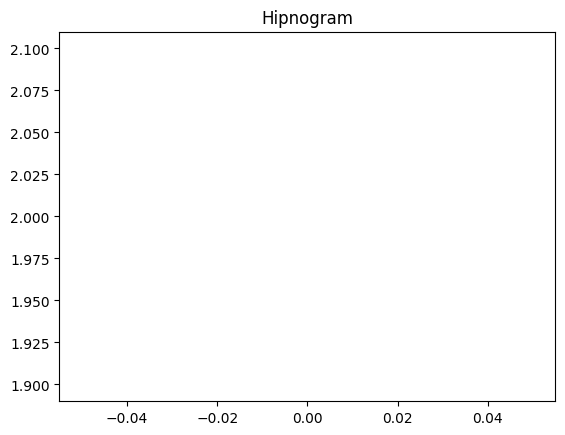

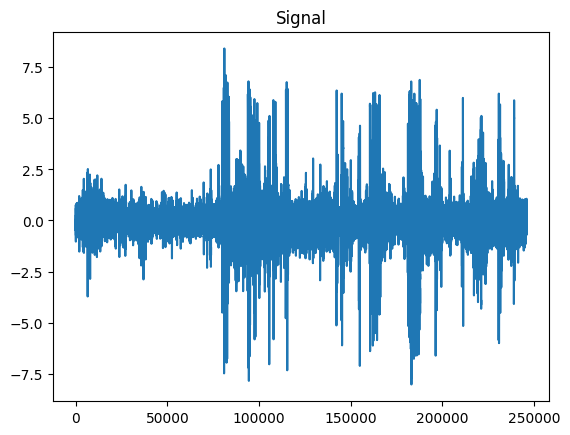

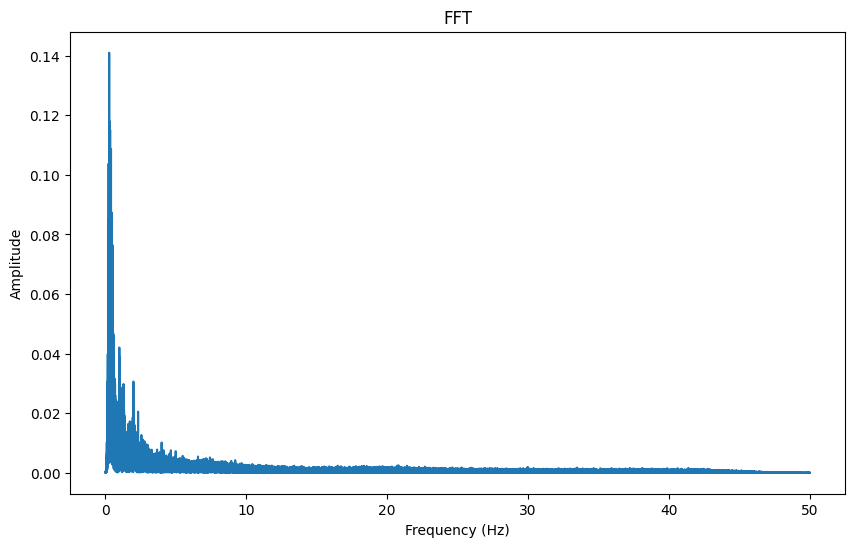

6
7


<Figure size 1000x600 with 0 Axes>

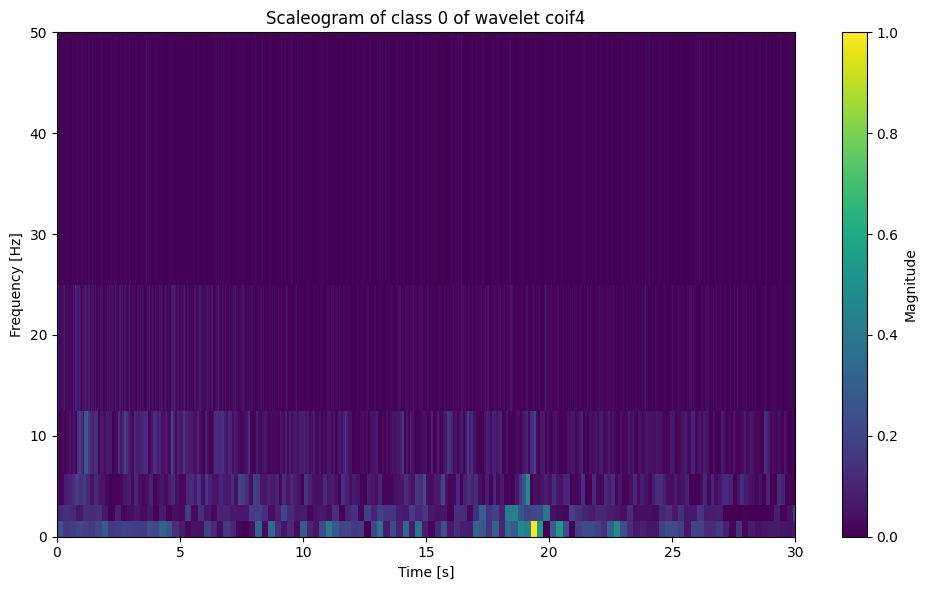

In [37]:
signal = x[0][3][0]
print(len(signal))
y_np = y.detach().cpu().numpy()
print(y_np.shape)
print(y_np)

# plot the hipnogram
plt.figure()
plt.plot(y.detach().cpu().numpy())
plt.title("Hipnogram")
plt.show()

# plot the signal
plt.figure()
plt.plot(small_test)
plt.title("Signal")
plt.show()

# plot fft
plot_fft(small_test, 100)

coeffs = pywt.wavedec(signal, 'coif4', level=5)
coeffs = upsampling_wavedec(len(signal), coeffs)
print(len(coeffs))
plot_dwt_scaleogram(coeffs.T, fs=100, t=30, w='coif4', label=0)

6
7


<Figure size 1000x600 with 0 Axes>

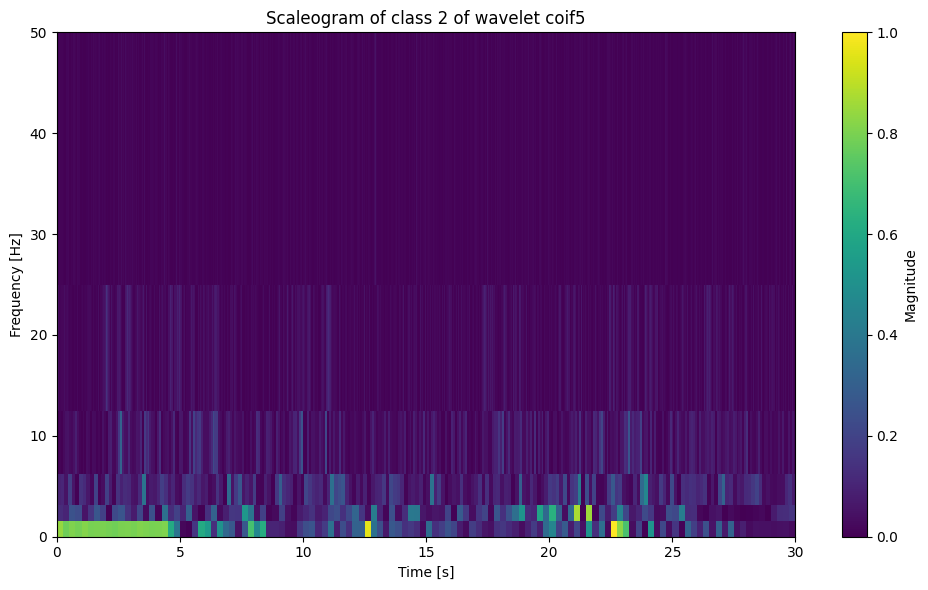

In [ ]:
signal_2 = x[120][3][0]

coeffs = pywt.wavedec(signal_2, 'coif5', level=5)
coeffs = upsampling_wavedec(len(signal_2), coeffs)
print(len(coeffs))
plot_dwt_scaleogram(coeffs.T, fs=100, t=30, w='coif5', label=2)

In [38]:
def plot_scaleogram_wav_heatmap(signal, attribution, prediction:int, label:int, fs=1000 ):
    # print(attribution.shape)

    # Compute frequency bands
    freq_bands = [fs /  (2 ** (j + 1)) for j in range(len(attribution[0]))]   # bands
    freq_bands.append(0)                                        # lowest frequency
    freq_bands = freq_bands[::-1]                               # reverse the order
    # print(freq_bands)

    if label == 0:
        class_name = "Wake"
    elif label == 1:
        class_name = "N1"
    elif label == 2:
        class_name = "N2"
    elif label == 3:
        class_name = "N3/N4"
    elif label == 4:
        class_name = "REM"
    

    time = np.linspace(0, signal / fs, signal)
    

    # normalize attribution scores to [0,1]
    attribution = np.abs(attribution)
    attr_norm = (attribution - attribution.min()) / (attribution.max() - attribution.min() + 1e-10)

    # Create a 2D grid for heatmap
    time_grid, freq_grid = np.meshgrid(time, freq_bands)
    # make attr x one dim smaller
    attr_norm = attr_norm[1:,:]

    # Plot the scaleogram
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(time_grid, freq_grid, attr_norm.T, shading='auto', cmap='Greens')
    plt.colorbar(label="Normalized Attribution Score")
    plt.title(f'{class_name}')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')

    plt.show()

In [33]:
print(len(scores))
print(len(scores[0]))
print(len(scores[0][0]))
print(len(scores[0][0][0]))


1
128
7
3000


In [15]:
print(attributions.keys())

dict_keys(['deletion', 'insertion', 'predictions', 'labels', 'wavelet_coif4_5_128', 'filtermasks_wavelet_coif4_5_128'])


In [82]:
import torch.nn.functional as F

print(attributions['predictions'][0])

probabilities = F.softmax(attributions['predictions'][0], dim=0)
print(probabilities)

predicted = torch.argmax(attributions['predictions'][0], dim=0)
print(predicted)


predicted = []

for p in attributions['predictions']:
    # probabilities = F.softmax(p, dim=0)
    predicted.append(torch.argmax(p, dim=0))

print(len(predicted))



tensor([ 3.7968, -1.1244, -2.3120, -9.1935, -2.5675])
tensor([9.8889e-01, 7.2094e-03, 2.1984e-03, 2.2569e-06, 1.7028e-03])
tensor(0)
26322


wavelet_coif4_5_128
Total samples: 26322
Correctly classified: 11044
Total correctly classified: 11044
Counts of label 0: 3126, label 1: 399, label 2: 5008, label 3: 778, label 4: 1733
Shape of mask 0: (3000, 6), mask 1: (3000, 6), mask 2: (3000, 6), mask 3: (3000, 6), mask 4: (3000, 6)


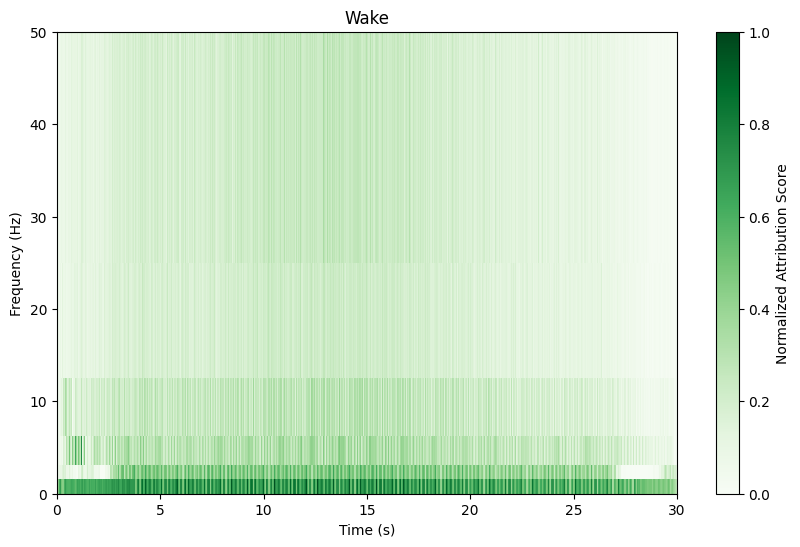

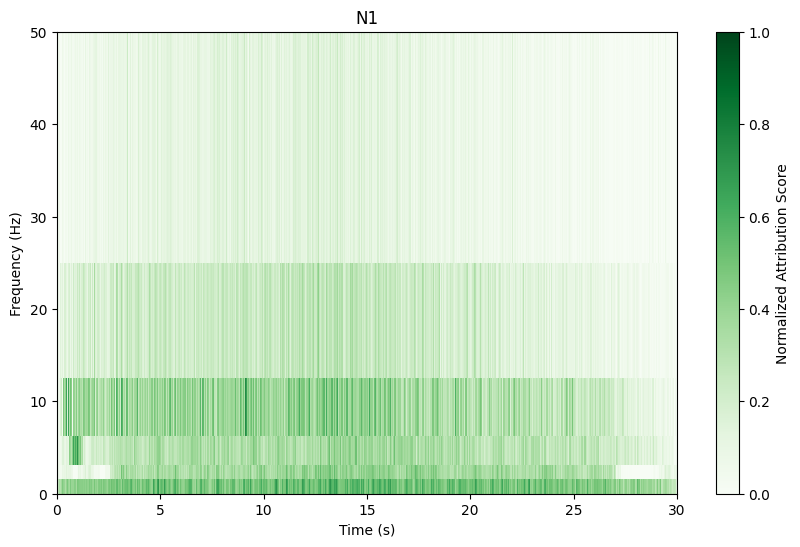

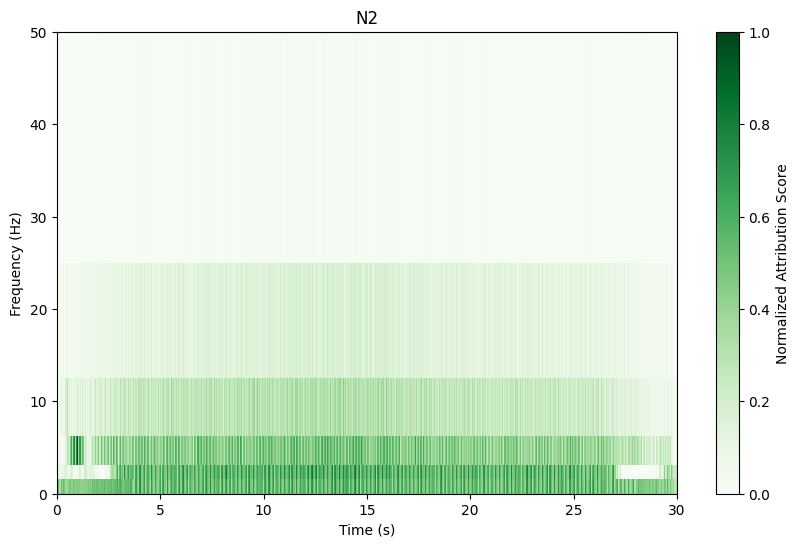

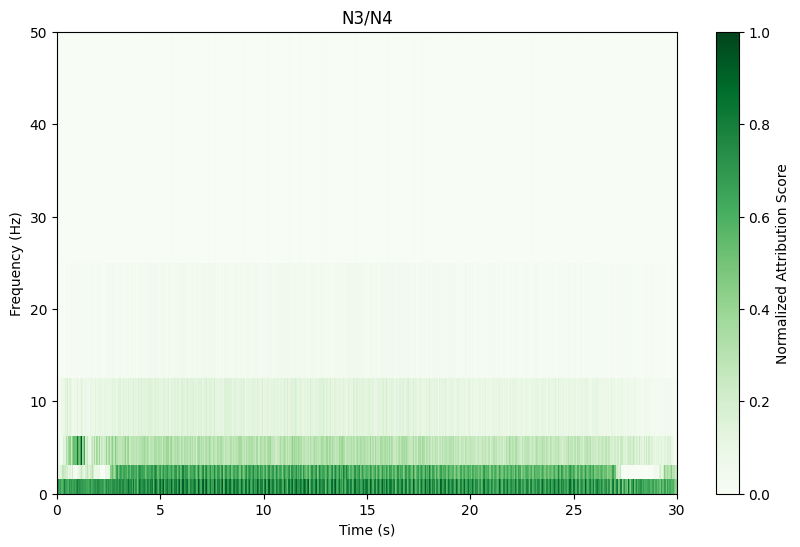

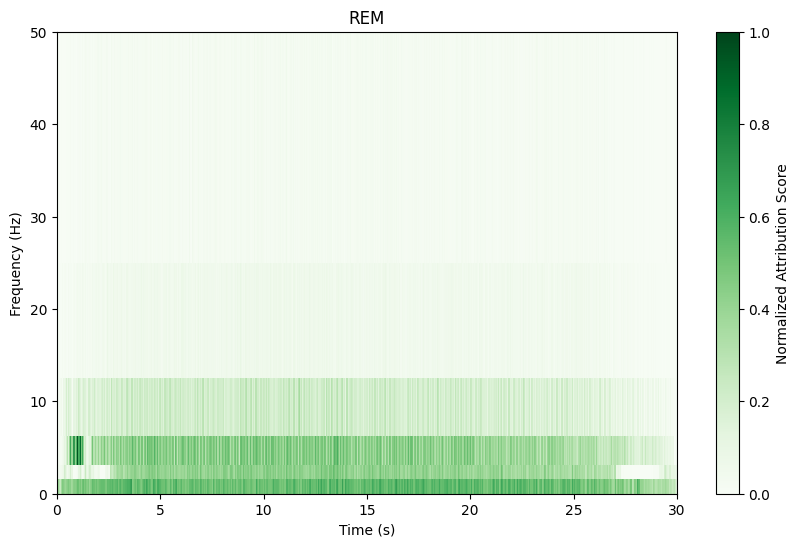

In [83]:
# "Sleep stage W": 0,
# "Sleep stage 1": 1,
# "Sleep stage 2": 2,

counts_0 = 0
counts_1 = 0
counts_2 = 0
counts_3 = 0
counts_4 = 0

data_length = 3000
fs = 100

# attributions['insertion']['wavelet_db1_4_128'] = scores

set_seed(42)
key_ = 'wavelet_coif4_5_128'
print(key_)

# for key in attributions['insertion'].keys():
#     print(key)

# method, wavelet, max_level, batch_size = key.split('_')
# max_level = int(max_level)

masks_0 = np.zeros_like(attributions[key_][0][0][0])
masks_1 = np.zeros_like(attributions[key_][0][0][0])
masks_2 = np.zeros_like(attributions[key_][0][0][0])
masks_3 = np.zeros_like(attributions[key_][0][0][0])
masks_4 = np.zeros_like(attributions[key_][0][0][0])

scores = attributions[key_]

index = 0
correct = 0

for i, batch in enumerate(test_loader):
    x, y = batch

    for j in range(len(scores[i])):
        if predicted[index] == attributions['labels'][index]:
            correct += 1
            results = scores[i][j][3].detach().cpu().numpy()    
            # print(index)
            if attributions['labels'][index] == 0:
                counts_0 += 1
                masks_0 += results
            elif attributions['labels'][index] == 1:
                counts_1 += 1
                masks_1 += results
            elif attributions['labels'][index] == 2:
                counts_2 += 1
                masks_2 += results
            elif attributions['labels'][index] == 3:
                counts_3 += 1
                masks_3 += results
            elif attributions['labels'][index] == 4:
                counts_4 += 1
                masks_4 += results

        index += 1

masks_0 /= counts_0
masks_1 /= counts_1
masks_2 /= counts_2
masks_3 /= counts_3
masks_4 /= counts_4

print(f"Total samples: {len(predicted)}")
print(f"Correctly classified: {correct}")
print(f"Total correctly classified: {counts_0 + counts_1 + counts_2 + counts_3 + counts_4}")
print(f"Counts of label 0: {counts_0}, label 1: {counts_1}, label 2: {counts_2}, label 3: {counts_3}, label 4: {counts_4}")
print(f"Shape of mask 0: {masks_0.shape}, mask 1: {masks_1.shape}, mask 2: {masks_2.shape}, mask 3: {masks_3.shape}, mask 4: {masks_4.shape}")

plot_scaleogram_wav_heatmap(data_length, masks_0, prediction=0, label=0, fs=fs)
plot_scaleogram_wav_heatmap(data_length, masks_1, prediction=1, label=1, fs=fs)
plot_scaleogram_wav_heatmap(data_length, masks_2, prediction=2, label=2, fs=fs)
plot_scaleogram_wav_heatmap(data_length, masks_3, prediction=3, label=3, fs=fs)
plot_scaleogram_wav_heatmap(data_length, masks_4, prediction=4, label=4, fs=fs)

# Counts of label 0: 3887, label 1: 1418, label 2: 5084, label 3: 809, label 4: 1986

    

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List


def plot_frequency_attribution(
    masks: List[np.ndarray],
    labels: List[int],
    fs: int = 100,
    data_length: int = 3000,
    max_level: int = 5,
    figsize: Tuple[int, int] = (20, 5)
):
    """
    Plot the frequency band attribution for each sleep stage.
    
    Args:
        masks: List of averaged wavelet masks for each sleep stage
        labels: List of corresponding sleep stage labels
        fs: Sampling frequency
        data_length: Length of the data in samples
        max_level: Maximum wavelet decomposition level
        figsize: Figure size (width, height)
    """
    # Calculate frequency bands based on wavelet decomposition
    # For wavelet transform, each level represents a different frequency band
    # The frequency bands are approximately: [f/2^(level+1), f/2^level]
    freq_bands = [fs /  (2 ** (j + 1)) for j in range(max_level)]   # bands
    freq_bands.append(0)                                            # lowest frequency
    freq_bands = freq_bands[::-1]    
    
    # Create subplots in a single row
    fig, axes = plt.subplots(1, len(masks), figsize=figsize, sharey=True)
    
    # Find the maximum absolute value for normalization
    max_abs_val = max(np.max(np.abs(np.sum(mask, axis=0))) for mask in masks)
    
    for i, (mask, label) in enumerate(zip(masks, labels)):
        # Integrate over time dimension (axis=1)
        freq_attribution = np.sum(mask, axis=0)
        
        # Normalize the attribution scores
        freq_attribution = freq_attribution / max_abs_val
        
        # Plot the frequency attribution
        ax = axes[i]
        
        # Create a line plot with frequency bands
        ax.plot(freq_bands, freq_attribution, marker='o', linestyle='-')
        
        # Format the plot
        ax.set_title(f'{label}', pad=10)
        ax.set_xlabel('Frequency (Hz)')
        
        # Set consistent limits
        ax.set_xlim(0, 30)
        ax.set_ylim(0, 1)
        
        # Add a horizontal line at y=0 for reference
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        
    
    # Add common x-axis label
    plt.tight_layout()
    plt.show()

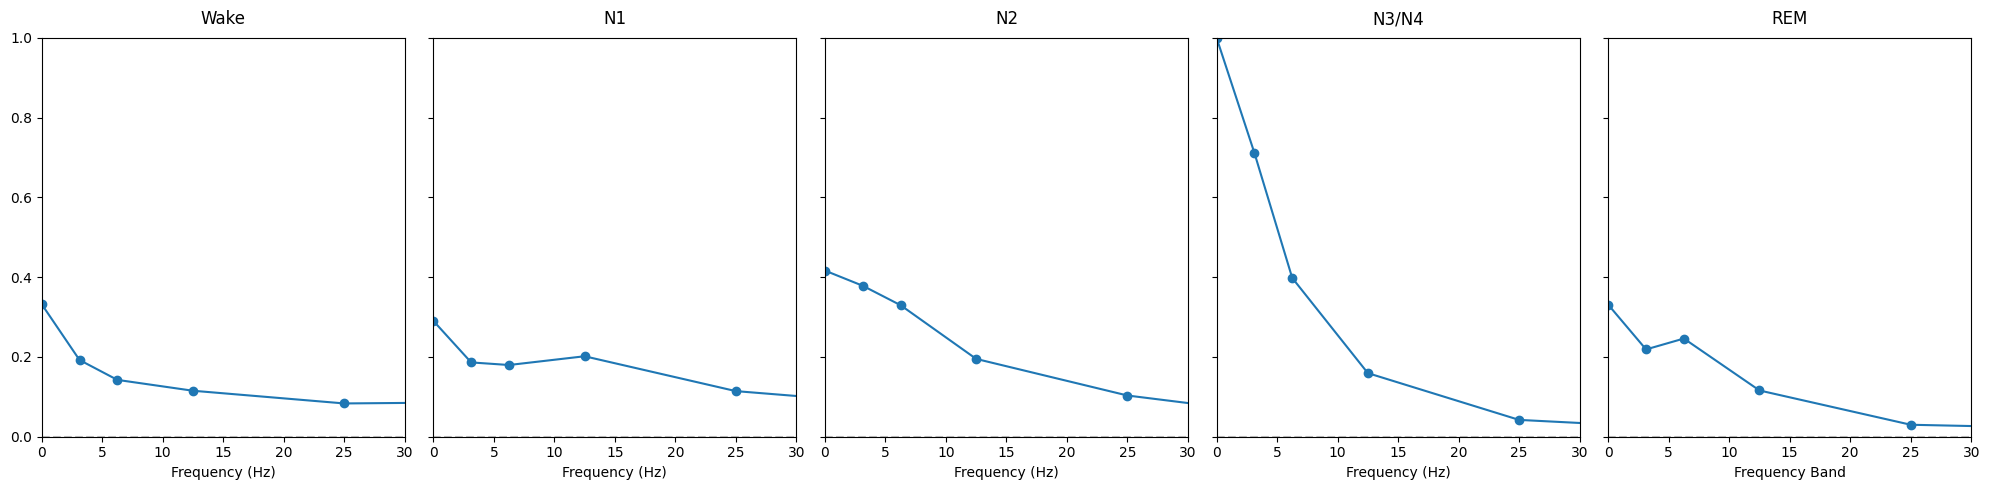

In [85]:
masks = [masks_0, masks_1, masks_2, masks_3, masks_4]
labels = ['Wake', 'N1', 'N2', 'N3/N4', 'REM']
    
plot_frequency_attribution(masks, labels, fs=100, data_length=3000, max_level=5)

In [ ]:
print(len(attributions[key_]))
print(len(attributions[f'filtermasks_{key_}']))


5
412


In [46]:
# save the results in a pkl file
folder = 'public/sleepedf/'
path = f'{folder}{key_}.pkl'

with open(path, 'wb') as f:
    pickle.dump(attributions, f)
print(f"Saved to {path}")

Saved to public/sleepedf/wavelet_coif5_5_128.pkl


Counts of label 0: 5000, label 1: 5000
1
1
2
4
8


<Figure size 1000x600 with 0 Axes>

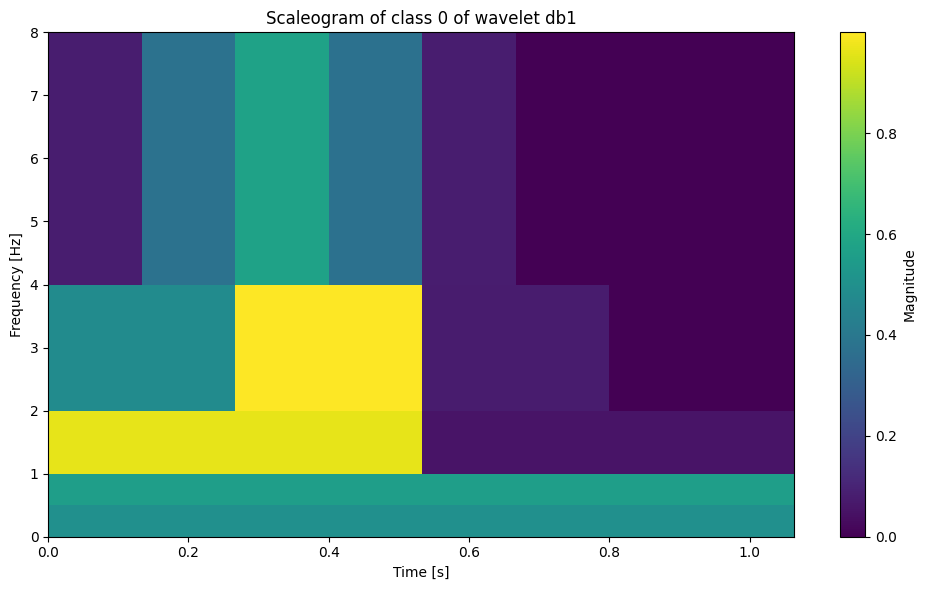

<Figure size 1000x600 with 0 Axes>

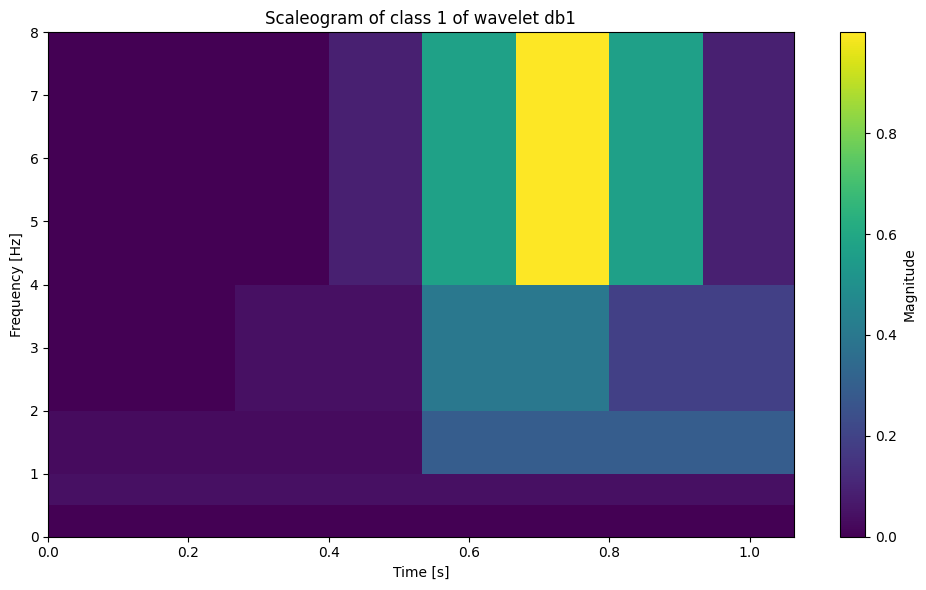

In [24]:
from src.utils.sampling import upsampling_wavedec

counts_0 = 0
counts_1 = 0

wavelets_0 = np.zeros((5, 16))
wavelets_1 = np.zeros((5, 16))

for batch in test_loader:
    x, y = batch
    
    for i, channels in enumerate(x):
        signal = channels[0].detach().cpu().numpy()

        coeffs = pywt.wavedec(signal, 'db1', level=4)
        upsampled = upsampling_wavedec(len(signal), coeffs)
        upsampled = np.abs(upsampled)

        if y[i] == 0:
            counts_0 += 1
            wavelets_0 += upsampled
        else:
            counts_1 += 1
            wavelets_1 += upsampled
    
wavelets_0 /= counts_0
wavelets_1 /= counts_1
    
print(f"Counts of label 0: {counts_0}, label 1: {counts_1}")

for c in coeffs:
    print(len(c))

upsampled = upsampling_wavedec(len(signal), coeffs)
downsampled = downsample_wavedec(len(signal), coeffs, 'db1', 1)

plot_dwt_scaleogram(wavelets_0.T, fs=fs, label=0)
plot_dwt_scaleogram(wavelets_1.T, fs=fs, label=1)